In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/google colab/kaggle.json" ~/.kaggle/

DataSet
"https://www.kaggle.com/datasets/msambare/fer2013"

In [ ]:
!kaggle datasets download -d msambare/fer2013

 76% 46.0M/60.3M [00:00<00:00, 246MB/s]
100% 60.3M/60.3M [00:00<00:00, 246MB/s]


In [ ]:
# import shutil
# import os
# shutil.rmtree("/content/drive/MyDrive/Emotion_Detection")

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fer2013.zip', 'r')
zip_ref.extractall('/content/drive/MyDrive/google colab/Emotion_Detection/data')
zip_ref.close()

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns
tf.random.set_seed(42)

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16,VGG19, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [2]:
base_dir = ''

In [3]:
models_dir = 'models'
models_dir = os.path.join(base_dir, models_dir)

model_names = [
    'Custom_CNN_model',
    'Custom_CNN_Augmentation_model',
    'VGG16_model',
    'VGG19_model',
    'ResNet50_model',
]

for model_name in model_names:
    path = os.path.join(models_dir, model_name)
    os.makedirs(path, exist_ok=True)

In [4]:
def count_img(path, set_type):
    counts = {}
    path = os.path.join(path, set_type)

    for class_name in os.listdir(path):
        class_path =  os.path.join(path, class_name)
        counts[class_name] = len(os.listdir(class_path))
    return counts

In [5]:
data_dir = "Data/data"
data_dir = os.path.join(base_dir, data_dir)

train_counts = count_img(data_dir , 'train')
test_counts = count_img(data_dir , 'test')

print(train_counts)
print(test_counts)

{'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}
{'angry': 958, 'disgust': 111, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}


In [6]:
def plot_counts(emotion_counts, set_type):
    emotions = list(emotion_counts.keys())
    counts = list(emotion_counts.values())

    plt.figure(figsize=(6, 4))
    plt.bar(emotions, counts, color='skyblue')
    plt.xlabel('Emotions')
    plt.ylabel('Count')
    plt.title(set_type)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

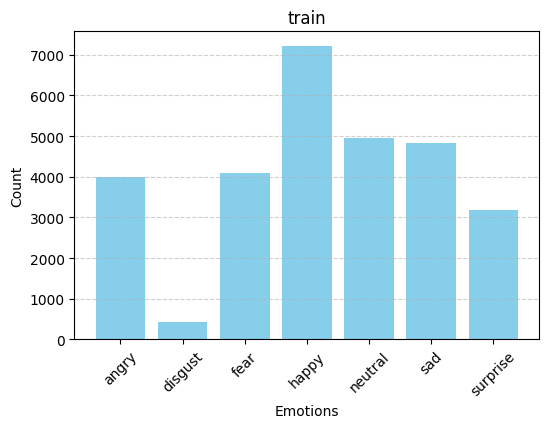

In [7]:
plot_counts(train_counts, 'train')

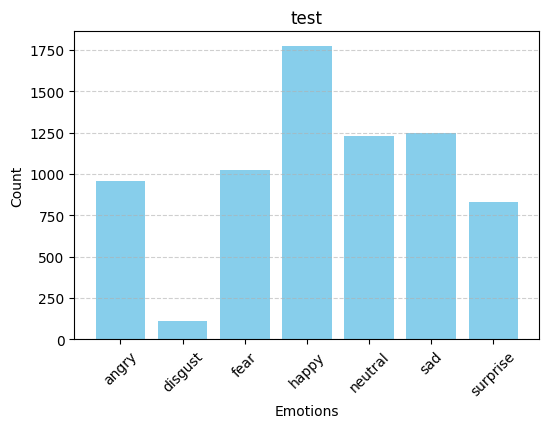

In [8]:
plot_counts(test_counts, 'test')

In [9]:
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

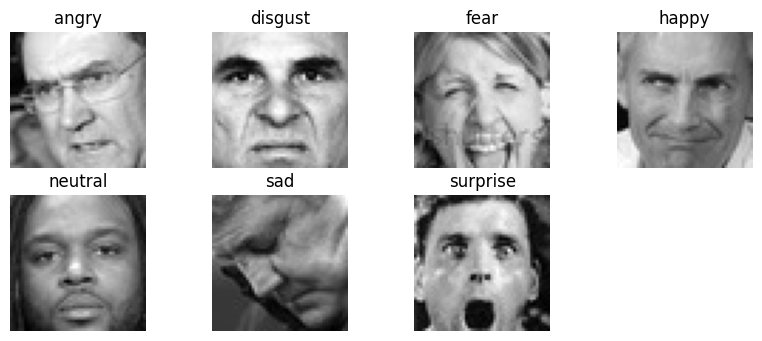

In [36]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(10,6))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

# **1. Custom CNN Model**

In [ ]:
img_width, img_height = 48, 48
batch_size = 64
epochs = 50
num_classes = 7

In [ ]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), padding='same',  activation='relu', input_shape=(img_width, img_height, 1)))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 48, 48, 128)       1280      
                                                                 
 conv2d_19 (Conv2D)          (None, 48, 48, 128)       147584    
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 128)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 24, 24, 64)       

In [ ]:
cnn_path = os.path.join(models_dir, model_names[0])
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps_per_epoch,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = test_steps_epoch,
    callbacks = callbacks
)

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 1.9611 - accuracy: 0.2168
Epoch 1: val_loss improved from inf to 1.82520, saving model to models\Custom_CNN_model\Custom_CNN_model.keras
449/449 [==============================] - 29s 61ms/step - loss: 1.9611 - accuracy: 0.2168 - val_loss: 1.8252 - val_accuracy: 0.2483 - lr: 1.0000e-04
Epoch 2/50
449/449 [==============================] - ETA: 0s - loss: 1.7949 - accuracy: 0.2588
Epoch 2: val_loss improved from 1.82520 to 1.73596, saving model to models\Custom_CNN_model\Custom_CNN_model.keras
449/449 [==============================] - 28s 61ms/step - loss: 1.7949 - accuracy: 0.2588 - val_loss: 1.7360 - val_accuracy: 0.3178 - lr: 1.0000e-04
Epoch 3/50
449/449 [==============================] - ETA: 0s - loss: 1.7370 - accuracy: 0.2936
Epoch 3: val_loss improved from 1.73596 to 1.66462, saving model to models\Custom_CNN_model\Custom_CNN_model.keras
449/449 [==============================] - 28s 62ms/step - loss: 1.7370

In [ ]:
def plot_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

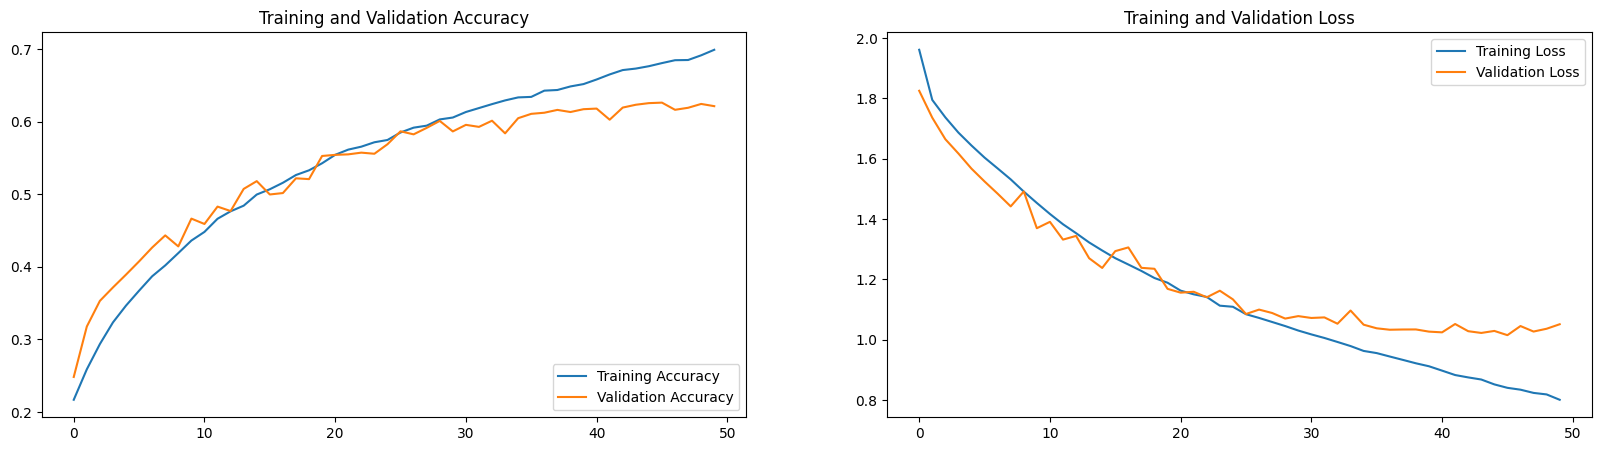

In [ ]:
plot_history(history)

## **Model Evaluation**

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 2s 20ms/step - loss: 1.0511 - accuracy: 0.6216
final train accuracy = 78.67 , validation accuracy = 62.16


## **Confusion Matrix**

113/113 [==============================] - 2s 19ms/step


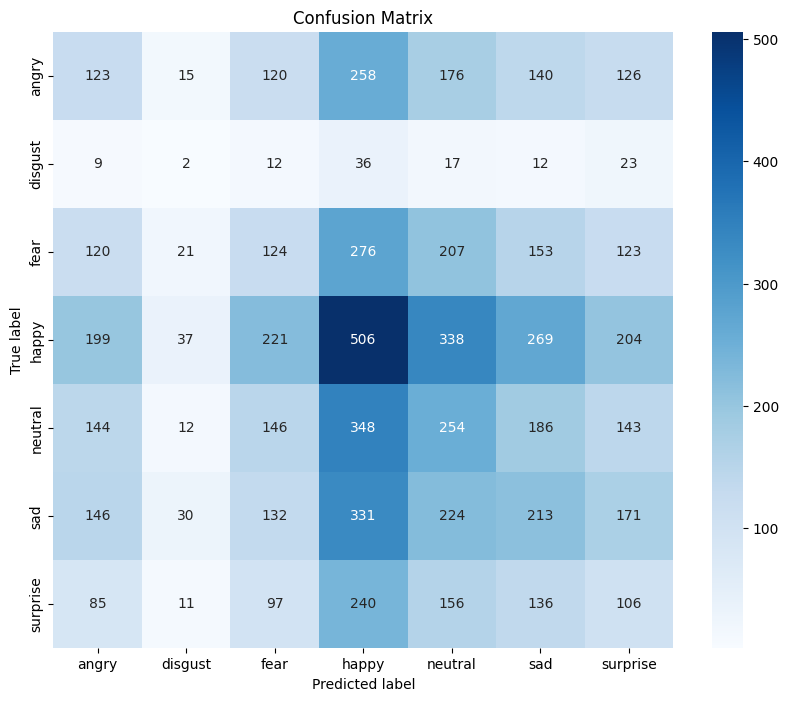

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Classification Report**

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.15      0.13      0.14       958
     disgust       0.02      0.02      0.02       111
        fear       0.15      0.12      0.13      1024
       happy       0.25      0.29      0.27      1774
     neutral       0.19      0.21      0.20      1233
         sad       0.19      0.17      0.18      1247
    surprise       0.12      0.13      0.12       831

    accuracy                           0.19      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.18      0.19      0.18      7178



## **Prediction**

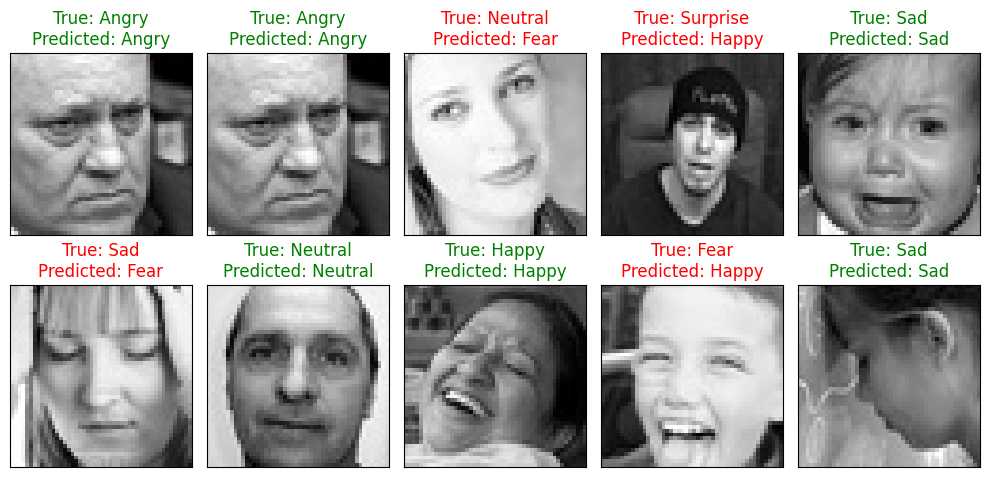

In [ ]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

batch_size = test_generator.batch_size

random_batch = np.random.randint(0, len(test_generator) - 1)

random_img_index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    random_img = test_generator[random_batch][0][random_img_index[i]]
    random_img_label = np.argmax(test_generator[random_batch][1][random_img_index[i]], axis=0)

    Model_Prediction = np.argmax(model.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1)[0]


    ax.imshow(random_img.squeeze(), cmap='gray')

    color = "green" if Emotion_Classes[random_img_label] == Emotion_Classes[Model_Prediction] else "red"

    ax.set_title(f"True: {Emotion_Classes[random_img_label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# **Model 2 : Custom CNN Model With Augmentation**

In [ ]:
img_width, img_height = 48, 48
batch_size = 64
epochs = 50
num_classes = 7


data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_data_generator = ImageDataGenerator(rescale=1./255)


train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')


test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), padding='same',  activation='relu', input_shape=(img_width, img_height, 1)))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 48, 48, 128)       1280      
                                                                 
 conv2d_25 (Conv2D)          (None, 48, 48, 128)       147584    
                                                                 
 batch_normalization_3 (Batc  (None, 48, 48, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 128)      0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 24, 24, 128)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 24, 24, 64)       

In [ ]:
cnn_path = os.path.join(models_dir, model_names[1])
name = 'Custom_CNN_Augmentation_model.keras'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps_per_epoch,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = test_steps_epoch,
    callbacks=callbacks
)

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 1.9611 - accuracy: 0.2045
Epoch 1: val_loss improved from inf to 1.88695, saving model to models\Custom_CNN_Augmentation_model\Custom_CNN_Augmentation_model.keras
449/449 [==============================] - 29s 63ms/step - loss: 1.9611 - accuracy: 0.2045 - val_loss: 1.8870 - val_accuracy: 0.2471 - lr: 1.0000e-04
Epoch 2/50
449/449 [==============================] - ETA: 0s - loss: 1.8301 - accuracy: 0.2305
Epoch 2: val_loss improved from 1.88695 to 1.79489, saving model to models\Custom_CNN_Augmentation_model\Custom_CNN_Augmentation_model.keras
449/449 [==============================] - 27s 61ms/step - loss: 1.8301 - accuracy: 0.2305 - val_loss: 1.7949 - val_accuracy: 0.2598 - lr: 1.0000e-04
Epoch 3/50
449/449 [==============================] - ETA: 0s - loss: 1.8112 - accuracy: 0.2391
Epoch 3: val_loss did not improve from 1.79489
449/449 [==============================] - 27s 60ms/step - loss: 1.8112 - accuracy: 0.2

In [ ]:
def plot_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

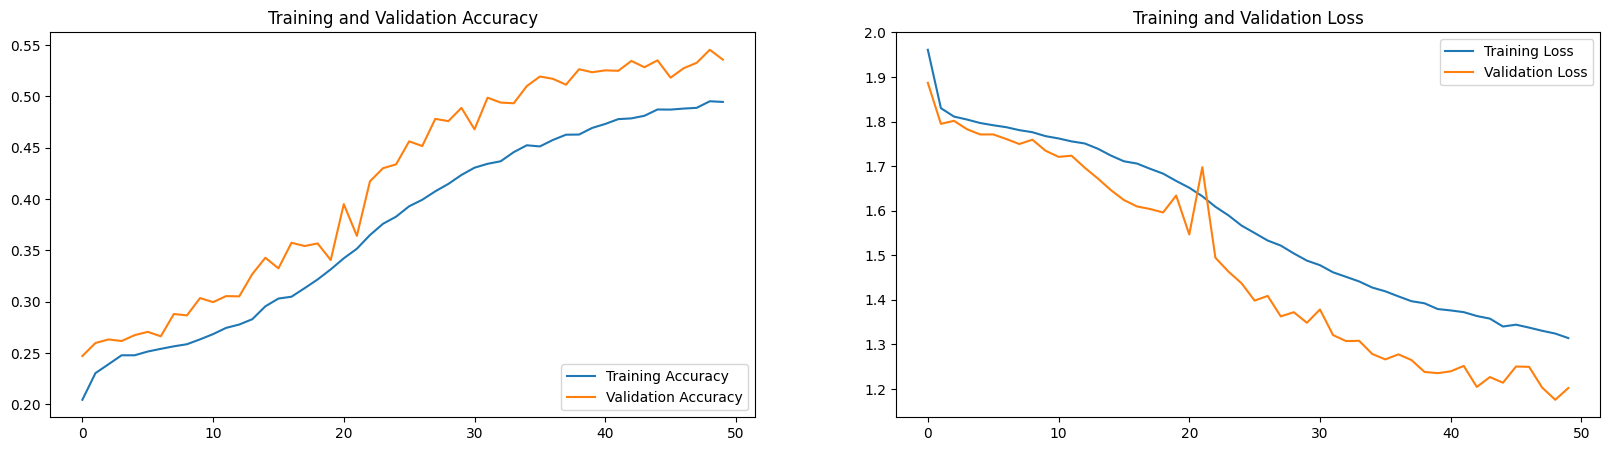

In [ ]:
plot_history(history)

## **Model Evaluation**

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 2s 19ms/step - loss: 1.2022 - accuracy: 0.5358
final train accuracy = 50.61 , validation accuracy = 53.58


## **Confusion Matrix**

113/113 [==============================] - 2s 20ms/step


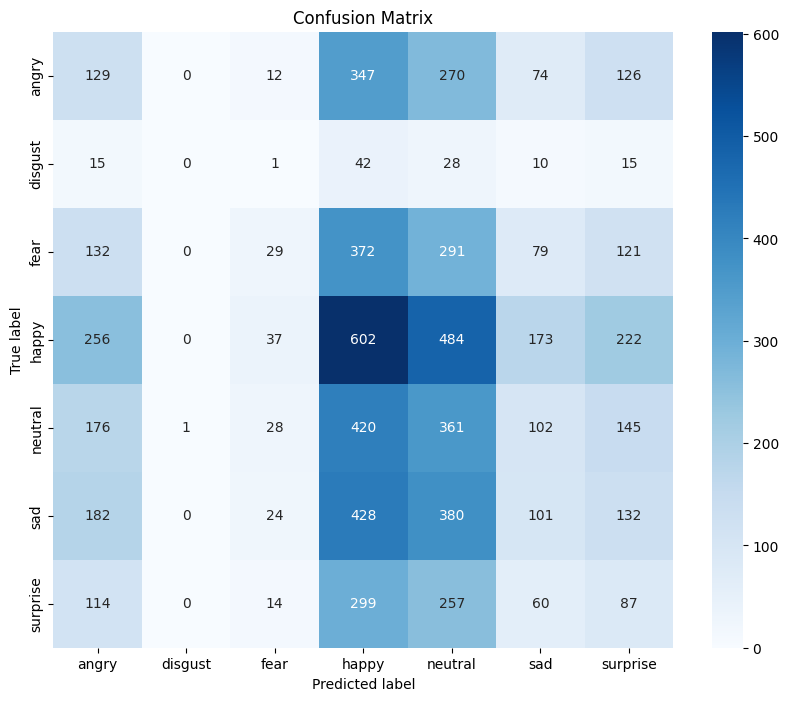

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Classification Report**

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.13      0.13       958
     disgust       0.00      0.00      0.00       111
        fear       0.20      0.03      0.05      1024
       happy       0.24      0.34      0.28      1774
     neutral       0.17      0.29      0.22      1233
         sad       0.17      0.08      0.11      1247
    surprise       0.10      0.10      0.10       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.18      0.18      0.16      7178



## **Prediction**

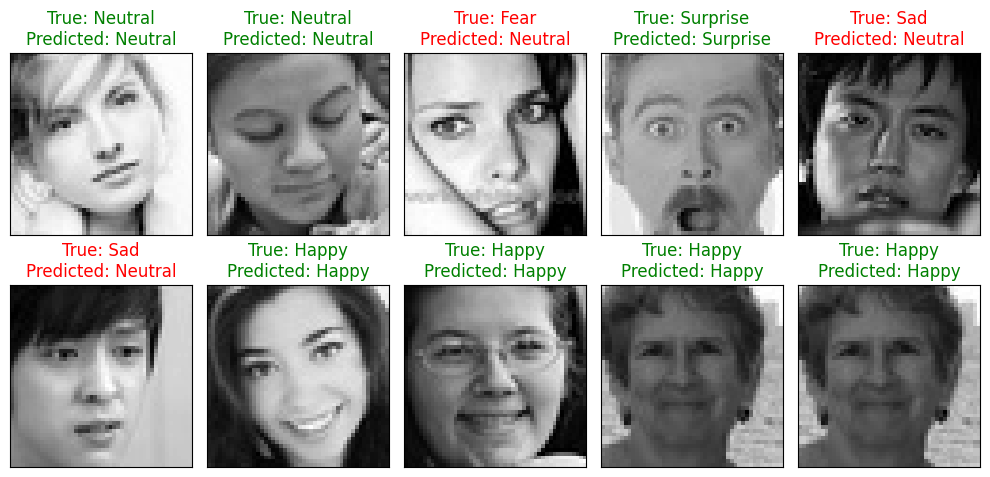

In [ ]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

batch_size = test_generator.batch_size

random_batch = np.random.randint(0, len(test_generator) - 1)

random_img_index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    random_img = test_generator[random_batch][0][random_img_index[i]]
    random_img_label = np.argmax(test_generator[random_batch][1][random_img_index[i]], axis=0)

    Model_Prediction = np.argmax(model.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1)[0]


    ax.imshow(random_img.squeeze(), cmap='gray')

    color = "green" if Emotion_Classes[random_img_label] == Emotion_Classes[Model_Prediction] else "red"

    ax.set_title(f"True: {Emotion_Classes[random_img_label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

## **Model 3 : VGG16**

In [47]:
img_width, img_height = 150, 150
batch_size = 32
epochs = 50
num_classes = 7

data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_generator = data_generator.flow_from_directory(
                                train_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                shuffle=False,
                                color_mode='rgb',)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [48]:
classes = np.array(train_generator.classes)


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [49]:
tf.keras.backend.clear_session()

conv_base = VGG16(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')

In [50]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block4_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [51]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [52]:
model = Sequential()

model.add(conv_base)
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())


model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))



model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(num_classes,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 4, 4, 512)         0         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [53]:
cnn_path = os.path.join(models_dir, model_names[2])
name = 'VGG16_model.keras'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor = 'val_accuracy',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [54]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [55]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    class_weight=class_weights_dict,
                    callbacks = callbacks
                    )

Epoch 1/50
898/898 [==============================] - ETA: 0s - loss: 2.0719 - accuracy: 0.1811
Epoch 1: val_loss improved from inf to 1.85893, saving model to models\VGG16_model\VGG16_model.keras
898/898 [==============================] - 153s 164ms/step - loss: 2.0719 - accuracy: 0.1811 - val_loss: 1.8589 - val_accuracy: 0.1987 - lr: 0.0010
Epoch 2/50
898/898 [==============================] - ETA: 0s - loss: 1.8065 - accuracy: 0.2449
Epoch 2: val_loss improved from 1.85893 to 1.76598, saving model to models\VGG16_model\VGG16_model.keras
898/898 [==============================] - 143s 160ms/step - loss: 1.8065 - accuracy: 0.2449 - val_loss: 1.7660 - val_accuracy: 0.2668 - lr: 0.0010
Epoch 3/50
898/898 [==============================] - ETA: 0s - loss: 1.7302 - accuracy: 0.2977
Epoch 3: val_loss did not improve from 1.76598
898/898 [==============================] - 143s 159ms/step - loss: 1.7302 - accuracy: 0.2977 - val_loss: 20.7678 - val_accuracy: 0.3168 - lr: 0.0010
Epoch 4/50
898

In [56]:
def plot_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

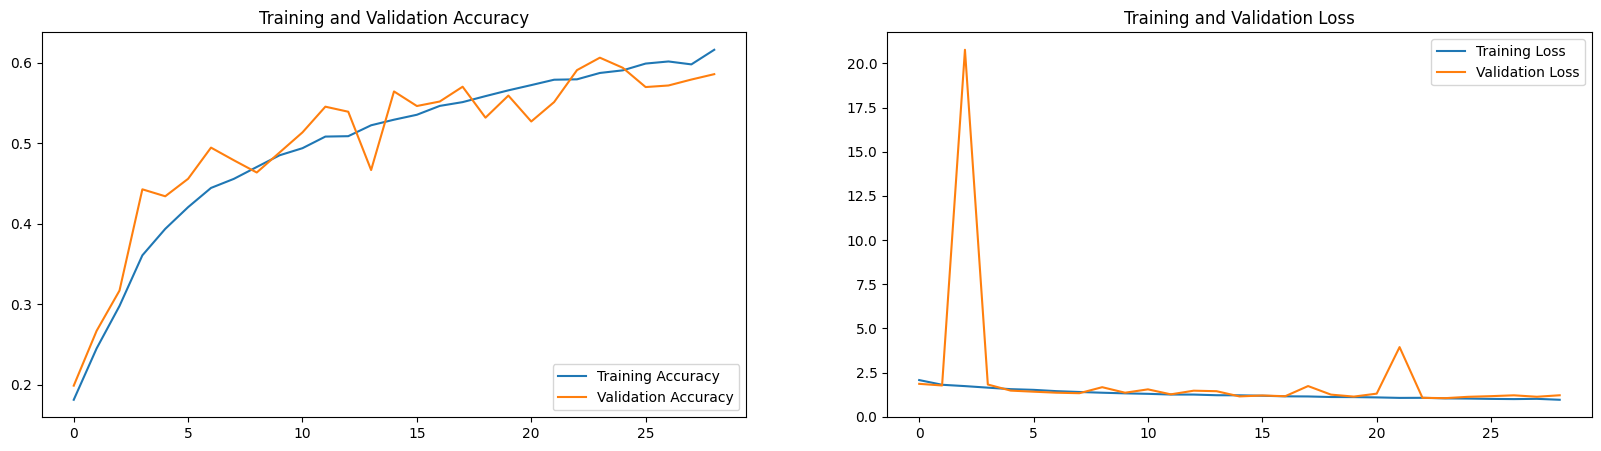

In [57]:
plot_history(history)

## **Model Evaluation**

In [58]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

225/225 [==============================] - 19s 83ms/step - loss: 1.0483 - accuracy: 0.6062
final train accuracy = 63.39 , validation accuracy = 60.62


## **Confusion Matrix**

225/225 [==============================] - 18s 80ms/step


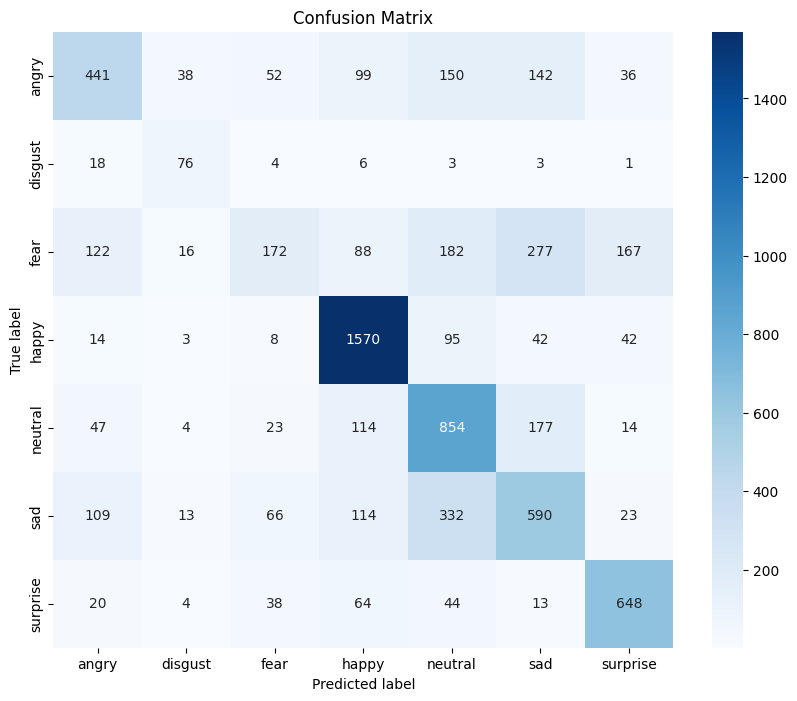

In [59]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Classification Report**

In [60]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.57      0.46      0.51       958
     disgust       0.49      0.68      0.57       111
        fear       0.47      0.17      0.25      1024
       happy       0.76      0.89      0.82      1774
     neutral       0.51      0.69      0.59      1233
         sad       0.47      0.47      0.47      1247
    surprise       0.70      0.78      0.74       831

    accuracy                           0.61      7178
   macro avg       0.57      0.59      0.56      7178
weighted avg       0.59      0.61      0.58      7178



## **Prediction**

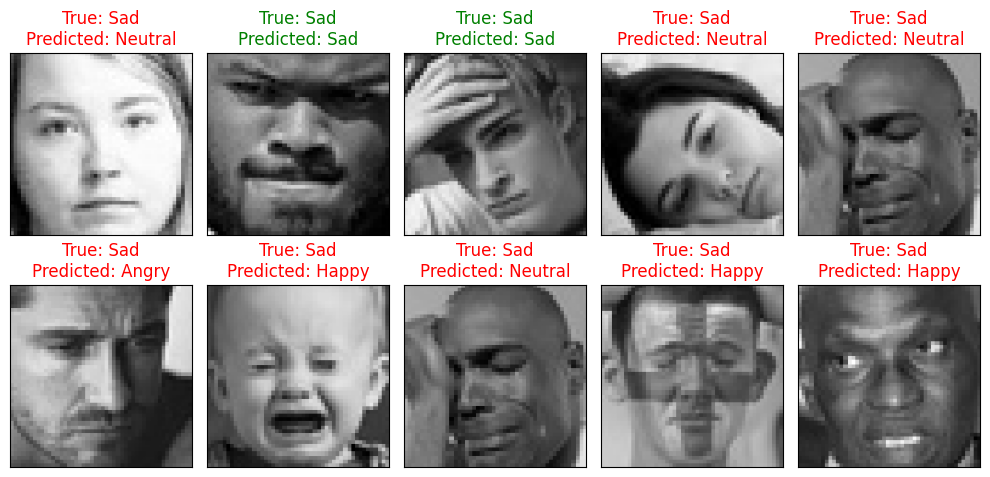

In [61]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

batch_size = test_generator.batch_size

random_batch = np.random.randint(0, len(test_generator) - 1)

random_img_index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    random_img = test_generator[random_batch][0][random_img_index[i]]
    random_img_label = np.argmax(test_generator[random_batch][1][random_img_index[i]], axis=0)

    Model_Prediction = np.argmax(model.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1)[0]


    ax.imshow(random_img.squeeze(), cmap='gray')

    color = "green" if Emotion_Classes[random_img_label] == Emotion_Classes[Model_Prediction] else "red"

    ax.set_title(f"True: {Emotion_Classes[random_img_label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

## **Model 4: VGG19**

In [77]:
img_width, img_height = 150, 150
batch_size = 32
epochs = 50
num_classes = 7

data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_generator = data_generator.flow_from_directory(
                                train_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [78]:
conv_base = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
    input_shape=(img_width, img_height, 3)
)
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [79]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


In [80]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [81]:
model = Sequential()

model.add(conv_base)
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(num_classes,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 dropout_6 (Dropout)         (None, 4, 4, 512)         0         
                                                                 
 batch_normalization_6 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              8389632   
                                                                 
 batch_normalization_7 (Batc  (None, 1024)             4096      
 hNormalization)                                      

In [82]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
cnn_path = os.path.join(models_dir, model_names[3])
name = 'VGG19_model.keras'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=6,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [84]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [85]:
train_history = model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=epochs,
                          validation_data=test_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                         )

Epoch 1/50
898/898 [==============================] - ETA: 0s - loss: 2.0120 - accuracy: 0.2074
Epoch 1: val_loss improved from inf to 2.01309, saving model to models\VGG19_model\VGG19_model.keras
898/898 [==============================] - 130s 143ms/step - loss: 2.0120 - accuracy: 0.2074 - val_loss: 2.0131 - val_accuracy: 0.2262 - lr: 0.0010
Epoch 2/50
898/898 [==============================] - ETA: 0s - loss: 1.6751 - accuracy: 0.3453
Epoch 2: val_loss improved from 2.01309 to 1.51791, saving model to models\VGG19_model\VGG19_model.keras
898/898 [==============================] - 129s 143ms/step - loss: 1.6751 - accuracy: 0.3453 - val_loss: 1.5179 - val_accuracy: 0.4081 - lr: 0.0010
Epoch 3/50
898/898 [==============================] - ETA: 0s - loss: 1.5141 - accuracy: 0.4145
Epoch 3: val_loss improved from 1.51791 to 1.43862, saving model to models\VGG19_model\VGG19_model.keras
898/898 [==============================] - 131s 146ms/step - loss: 1.5141 - accuracy: 0.4145 - val_loss: 

In [86]:
def plot_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

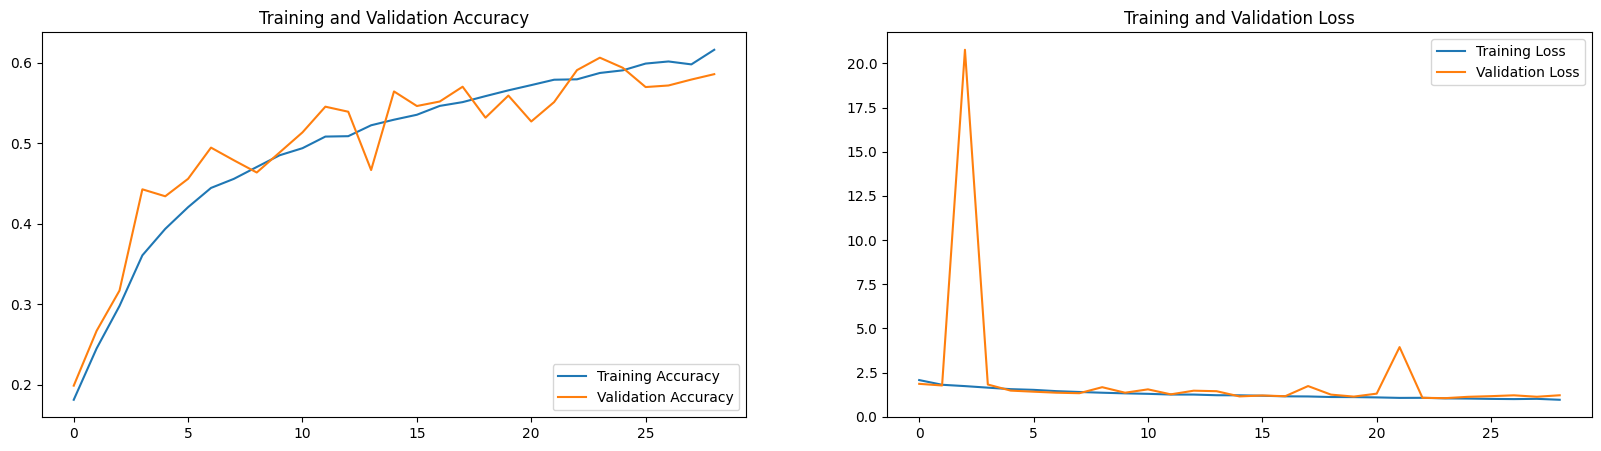

In [87]:
plot_history(history)

In [88]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

225/225 [==============================] - 22s 98ms/step - loss: 0.9836 - accuracy: 0.6602
final train accuracy = 75.90 , validation accuracy = 66.02


225/225 [==============================] - 22s 96ms/step


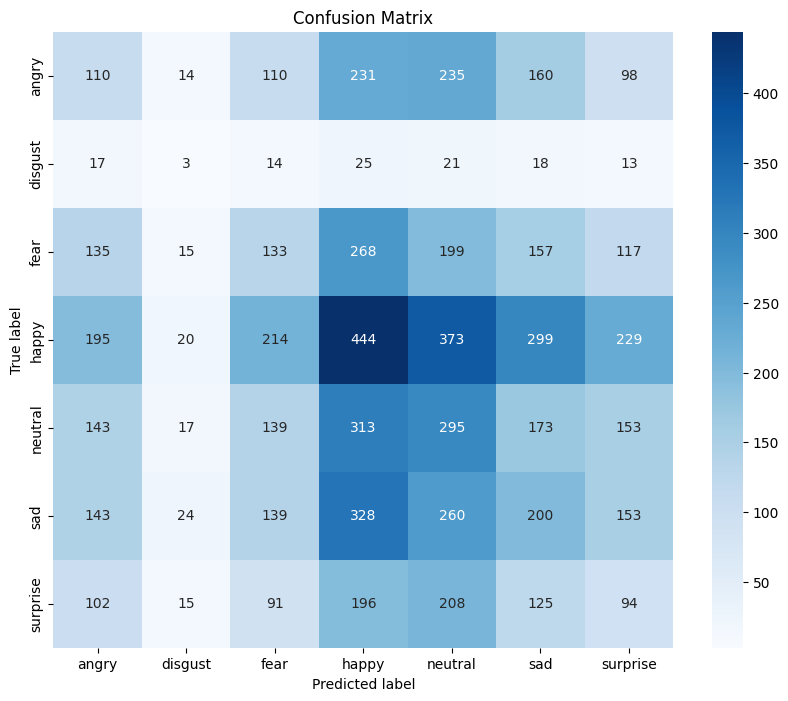

In [89]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [90]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.11      0.12       958
     disgust       0.03      0.03      0.03       111
        fear       0.16      0.13      0.14      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.19      0.24      0.21      1233
         sad       0.18      0.16      0.17      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.18      0.18      0.18      7178



# **Prediction**

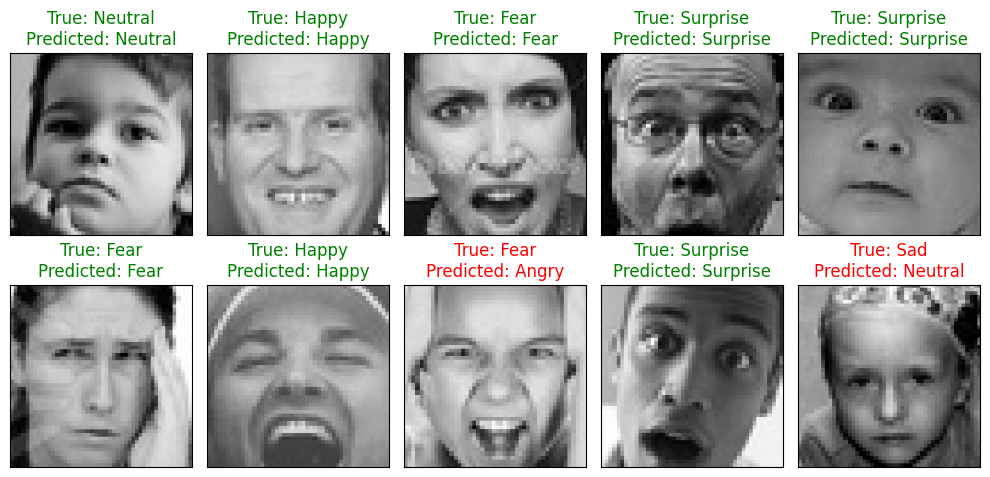

In [91]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

batch_size = test_generator.batch_size

random_batch = np.random.randint(0, len(test_generator) - 1)

random_img_index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    random_img = test_generator[random_batch][0][random_img_index[i]]
    random_img_label = np.argmax(test_generator[random_batch][1][random_img_index[i]], axis=0)

    Model_Prediction = np.argmax(model.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1)[0]


    ax.imshow(random_img.squeeze(), cmap='gray')

    color = "green" if Emotion_Classes[random_img_label] == Emotion_Classes[Model_Prediction] else "red"

    ax.set_title(f"True: {Emotion_Classes[random_img_label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# **Model 5: ResNet50**

In [10]:
img_width, img_height = 150,150
batch_size = 32
epochs = 100
num_classes = 7

data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range = 10,
                                zoom_range = 0.2,
                                width_shift_range = 0.1,
                                height_shift_range = 0.1,
                                horizontal_flip = True,
                                fill_mode='nearest',
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_generator = data_generator.flow_from_directory(
                                train_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                shuffle=False,
                                color_mode='rgb')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [11]:
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)


class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [12]:
conv_base = tf.keras.applications.ResNet50V2(input_shape=(img_width, img_height, 3), include_top= False, weights='imagenet')
conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']    

In [13]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if 'conv4' in layer.name:
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
conv1_pad False
conv1_conv False
pool1_pad False
pool1_pool False
conv2_block1_preact_bn False
conv2_block1_preact_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_pad False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_out False
conv2_block2_preact_bn False
conv2_block2_preact_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_pad False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_out False
conv2_block3_preact_bn False
conv2_block3_preact_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_pad False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
max_pooling2d False
conv2_block3_3_conv False
conv2_block3_out False
conv3_block1_pre

In [14]:
conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']    

In [15]:
model = Sequential()

model.add(conv_base)
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Dense(num_classes,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 batch_normalization (BatchN  (None, 5, 5, 2048)       8192      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 1024)              52429824  
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [16]:
cnn_path = os.path.join(models_dir, model_names[4])
name = 'ResNet50_model.keras'
chk_path = os.path.join(cnn_path, name)


checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              verbose=1)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

callbacks = [checkpoint, earlystop, csv_logger]

In [17]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [18]:
history = model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=epochs,
                          validation_data=test_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                         )

Epoch 1/100
898/898 [==============================] - ETA: 0s - loss: 1.9477 - accuracy: 0.2709
Epoch 1: val_loss improved from inf to 16.87453, saving model to models\ResNet50_model\ResNet50_model.keras
898/898 [==============================] - 308s 331ms/step - loss: 1.9477 - accuracy: 0.2709 - val_loss: 16.8745 - val_accuracy: 0.2129
Epoch 2/100
898/898 [==============================] - ETA: 0s - loss: 1.7102 - accuracy: 0.3542
Epoch 2: val_loss improved from 16.87453 to 4.16292, saving model to models\ResNet50_model\ResNet50_model.keras
898/898 [==============================] - 117s 130ms/step - loss: 1.7102 - accuracy: 0.3542 - val_loss: 4.1629 - val_accuracy: 0.3617
Epoch 3/100
898/898 [==============================] - ETA: 0s - loss: 1.5822 - accuracy: 0.3941
Epoch 3: val_loss improved from 4.16292 to 1.70897, saving model to models\ResNet50_model\ResNet50_model.keras
898/898 [==============================] - 118s 131ms/step - loss: 1.5822 - accuracy: 0.3941 - val_loss: 1.

In [19]:
def plot_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

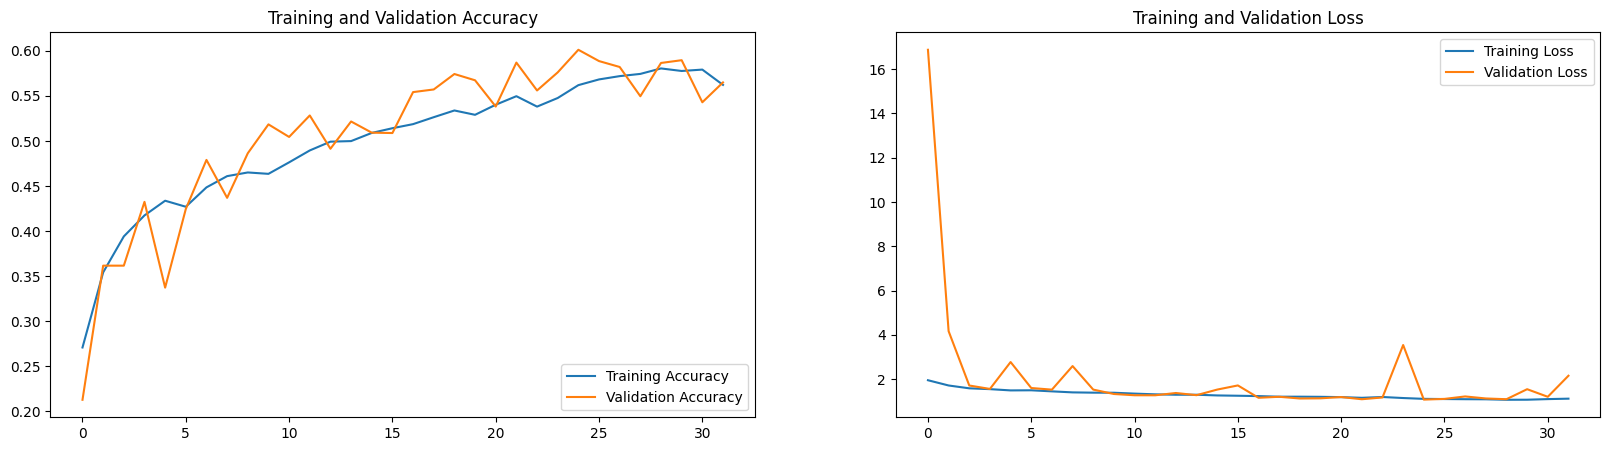

In [20]:
plot_history(history)

In [21]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

225/225 [==============================] - 11s 49ms/step - loss: 1.0721 - accuracy: 0.6011
final train accuracy = 59.15 , validation accuracy = 60.11


225/225 [==============================] - 11s 46ms/step


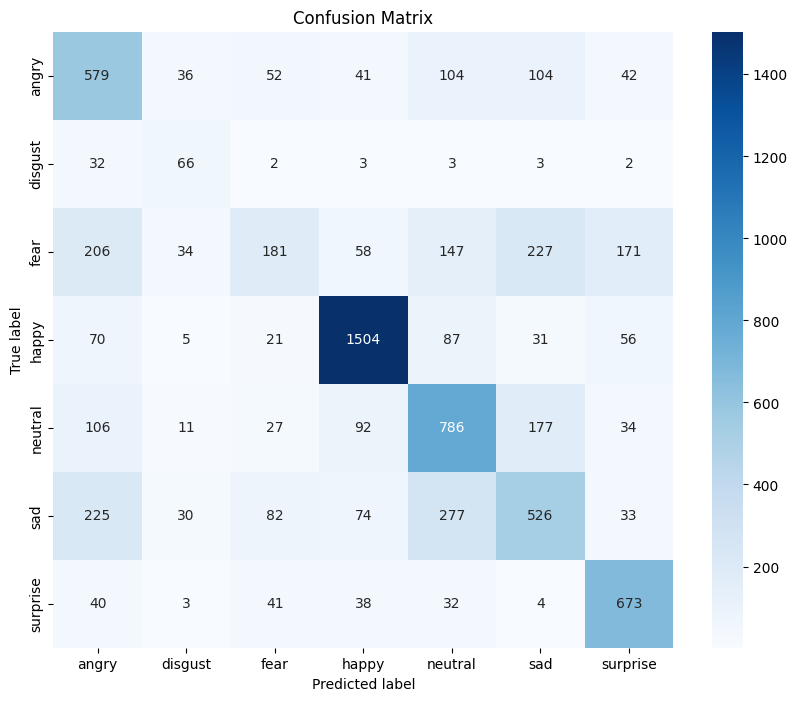

In [22]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [23]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.46      0.60      0.52       958
     disgust       0.36      0.59      0.45       111
        fear       0.45      0.18      0.25      1024
       happy       0.83      0.85      0.84      1774
     neutral       0.55      0.64      0.59      1233
         sad       0.49      0.42      0.45      1247
    surprise       0.67      0.81      0.73       831

    accuracy                           0.60      7178
   macro avg       0.54      0.58      0.55      7178
weighted avg       0.59      0.60      0.58      7178



# **Prediction**

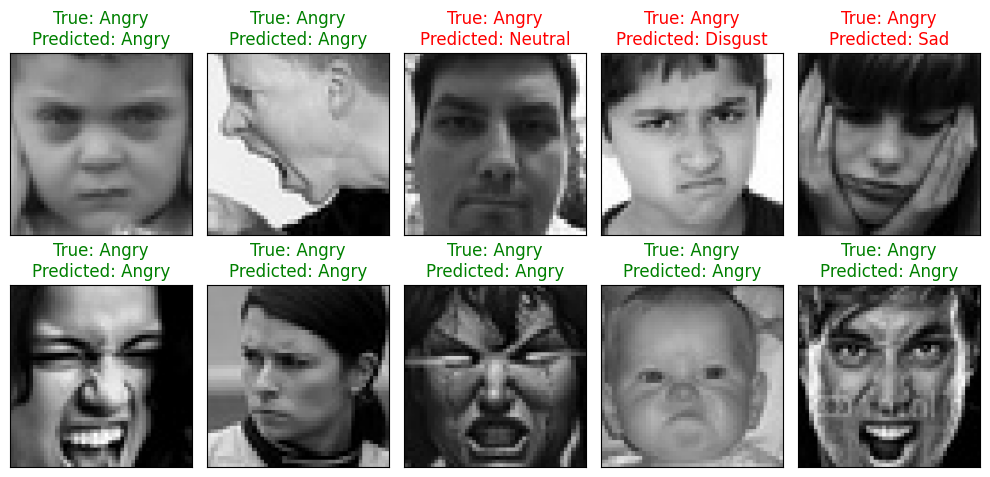

In [24]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

batch_size = test_generator.batch_size

random_batch = np.random.randint(0, len(test_generator) - 1)

random_img_index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    random_img = test_generator[random_batch][0][random_img_index[i]]
    random_img_label = np.argmax(test_generator[random_batch][1][random_img_index[i]], axis=0)

    Model_Prediction = np.argmax(model.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1)[0]


    ax.imshow(random_img.squeeze(), cmap='gray')

    color = "green" if Emotion_Classes[random_img_label] == Emotion_Classes[Model_Prediction] else "red"

    ax.set_title(f"True: {Emotion_Classes[random_img_label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()